**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**November, 2023**


---

# Manifold calculation of integrated of 24hpi and 48hpi datasets

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata

import seaborn as sns 

import matplotlib.pyplot as plt
import matplotlib as mpl
import gc


In [3]:
for folder in ['../results/images/']:
    if not os.path.exists(folder):
        os.makedirs(folder)
        #loop over the subfolders of the rawdata folder

In [4]:
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


'/opt/conda/bin/python'

In [4]:
def identityTransfer(adata_CellsNewID, adata, field='cell_type'):
    
    '''
    Function to transfer the value in a .obs column, modifying only the cells included in adata_CellsNewID
    
    Parameters:
        adata_CellsNewID: anndata object with cells. These should have in their .obs[field] the new values to be transfer to adata
        adata: anndata object to modify. The value in .obs[field] will be modifies for all the cells in adata_CellsNewID
        field: column name in .obs to operate in.
        
     Return:
        anndata object with the metadata modified
        
    '''
    
    #converting categorical into strings to introduce new categories
    adata.obs[field]=adata.obs[field].astype("string")


    #assigning the new categories to the cells in adata
    for cell in adata_CellsNewID.obs.index:
        adata.obs[field][cell] = adata_CellsNewID.obs[field][cell]

    #Returning strings into categorical 
    adata.obs[field]=adata.obs[field].astype("category")
    
    return(adata)

In [6]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= '', fig_format='svg'):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    ax1.set_xlim(0, 100)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.'+fig_format, bbox_inches='tight',
                       dpi=300, orientation='landscape', format= fig_format, optimize=True)

## Loading data

In [7]:
adata= sc.read('../results/rna_scVIintegrated_AllData.h5ad')


In [8]:
adata.X=adata.layers['raw_counts'].copy()

In [9]:
#Normalize and scale data to run neirest neighbors and plot gene expression
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:03)


In [10]:
del(adata.obsm["X_scVI_n_latent_40"])

### Plotting the different scVI latent spaces in UMAP embedation

In [40]:
#LATENT 20
sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_scVI_n_latent_20")
sc.tl.umap(adata)

#clustering
sc.tl.leiden(adata, key_added="leiden_scvi", resolution=0.3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:47)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_scvi', the cluster labels (adata.obs, categorical) (0:00:52)


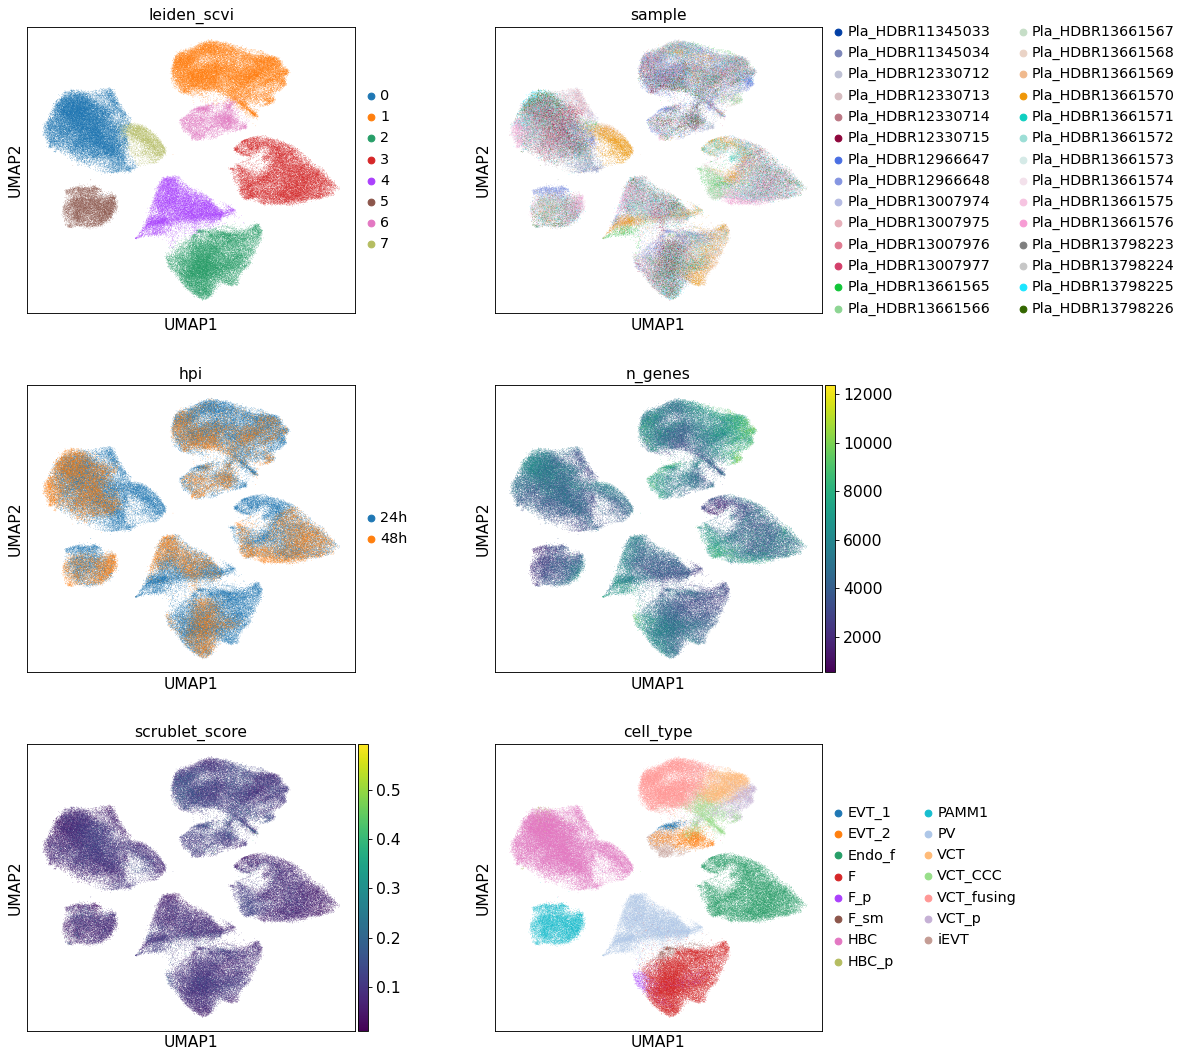

In [41]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=["leiden_scvi",'sample', 
                         'hpi','n_genes','scrublet_score','cell_type' ],
           ncols=2, wspace=0.3, save='_scVI_latent20.pdf')

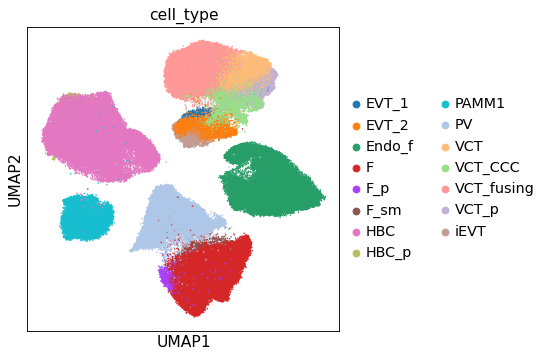

In [42]:
sc.set_figure_params(figsize=(5,5))

# use scVI imputed values for plotting
sc.pl.umap(adata, color=['cell_type' ],
           ncols=2, wspace=0.3, size=8)

In [11]:
#LATENT 30
sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_scVI_n_latent_30")
sc.tl.umap(adata)

#clustering
sc.tl.leiden(adata, key_added="leiden_scvi", resolution=0.3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:06)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_scvi', the cluster labels (adata.obs, categorical) (0:00:45)


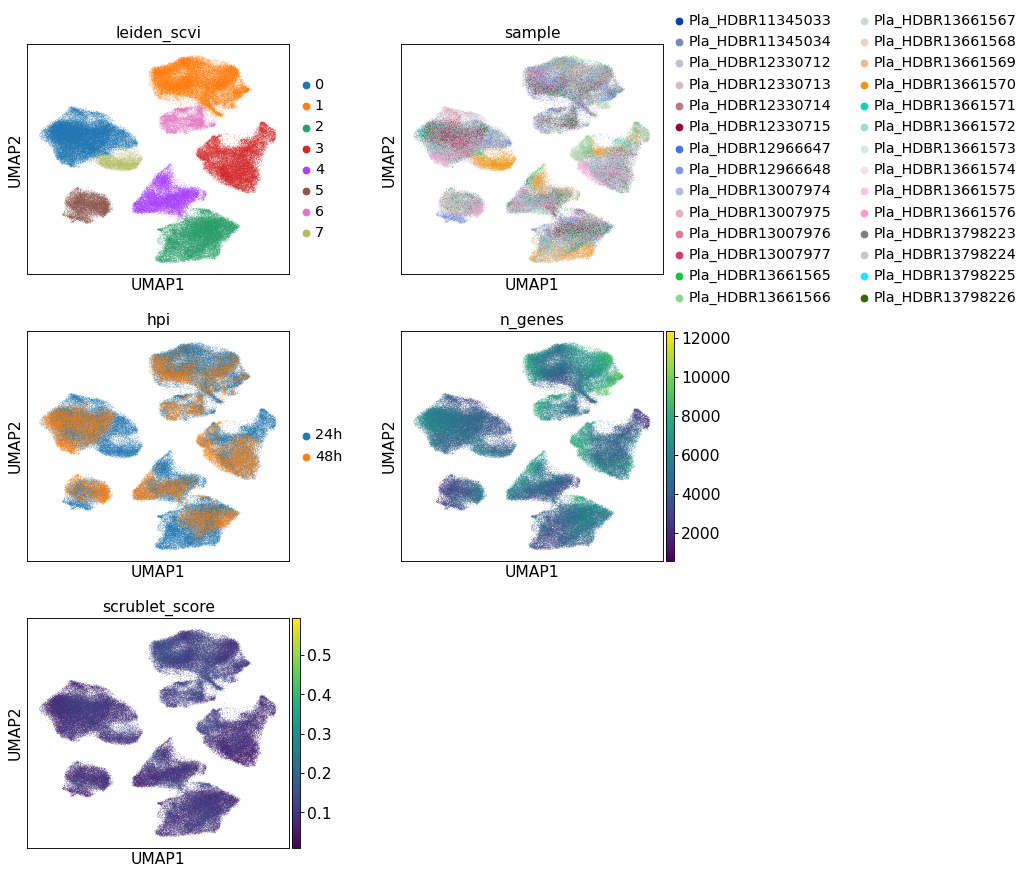

In [12]:
sc.set_figure_params(figsize=(4,4))

# use scVI imputed values for plotting
sc.pl.umap(adata, color=["leiden_scvi",'sample',#'donor_souporcell', 
                         'hpi','n_genes','scrublet_score']
           ,ncols=2,  wspace=0.3, save='_scVI_latent30.pdf')

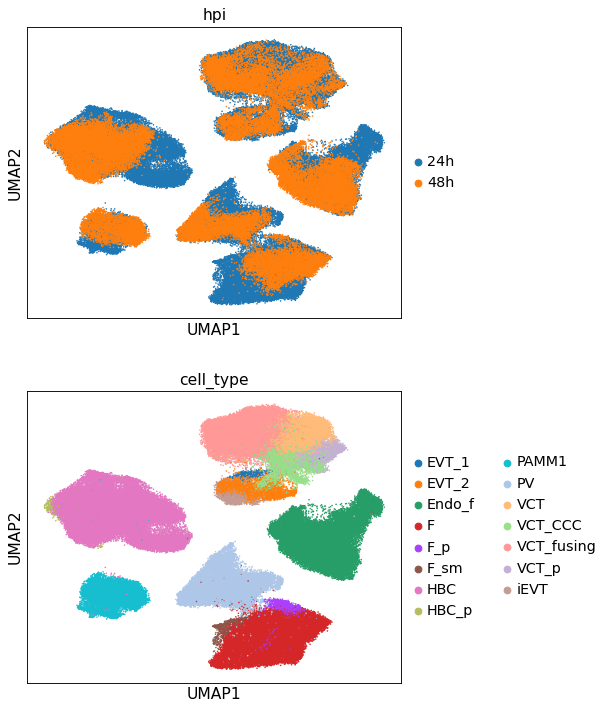

In [13]:
sc.set_figure_params(figsize=(5,5))

# use scVI imputed values for plotting
sc.pl.umap(adata, color=['hpi','cell_type' ],
           ncols=1, wspace=0.3, size=8)

In [14]:
temp = adata[adata.obs['hpi'].isin(['24h'])]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


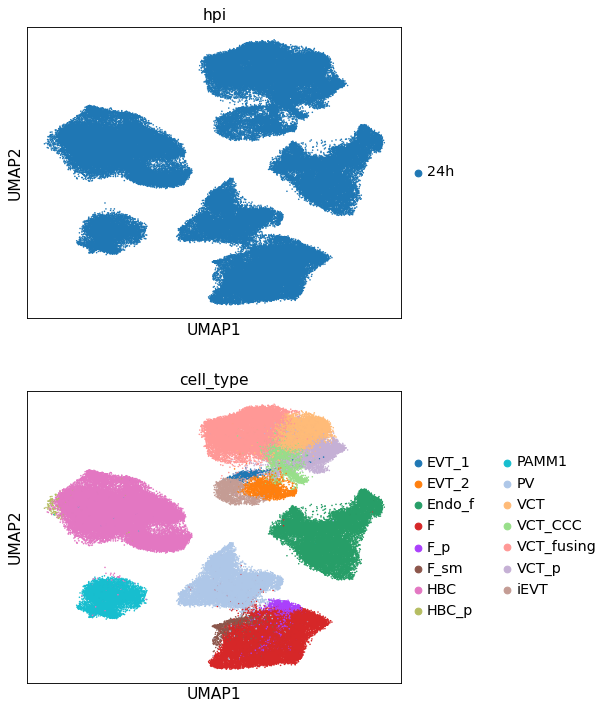

In [15]:
# use scVI imputed values for plotting
sc.pl.umap(temp, color=['hpi','cell_type' ],
           ncols=1, wspace=0.3, size=8)

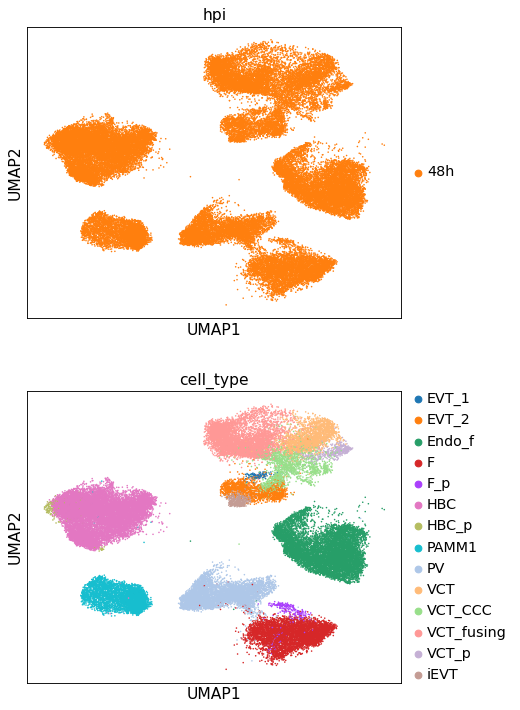

In [16]:
temp = adata[adata.obs['hpi'].isin(['48h'])]
# use scVI imputed values for plotting
sc.pl.umap(temp, color=['hpi','cell_type' ],
           ncols=1, wspace=0.3, size=8)

### Setting up color palette for future plots

In [17]:
sc.set_figure_params(figsize=(5,5))

In [18]:
#DF with the row names as the identity of the cells
colors_final_df = pd.DataFrame(index = np.unique(adata.obs['cell_type']))


#Assign each color per cell type under the column color

#colors_final_df.loc['SCT', 'color'] = '#f779a3'
colors_final_df.loc['VCT', 'color'] = '#b27ab4'
colors_final_df.loc['VCT_fusing', 'color'] = '#b53179'
colors_final_df.loc['VCT_p', 'color'] = '#993f98'
colors_final_df.loc['VCT_CCC', 'color'] = '#e2a7c8'

colors_final_df.loc['iEVT', 'color'] = '#0069b4'
colors_final_df.loc['EVT_1', 'color'] = '#009999'
colors_final_df.loc['EVT_2', 'color'] = '#03f9f2'


colors_final_df.loc['Endo_f', 'color'] = '#3f752d'
colors_final_df.loc['F', 'color'] = '#6bb300'
colors_final_df.loc['F_p', 'color'] = '#91A376'
colors_final_df.loc['F_sm', 'color'] = '#40C232'

colors_final_df.loc['PV', 'color'] = '#d6ff99'



colors_final_df.loc['HBC_p', 'color'] = '#7d303c'

colors_final_df.loc['HBC', 'color'] = '#db5669'
colors_final_df.loc['PAMM1', 'color'] = '#f7e55e'

colors_final_dict= colors_final_df.to_dict()['color']

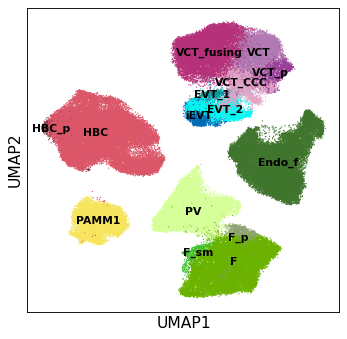

In [19]:
sc.pl.umap(adata, color=['cell_type'], size=5,
           palette= colors_final_dict, title='', legend_loc='on data',legend_fontsize='x-small')

In [20]:
adata

AnnData object with n_obs × n_vars = 158978 × 36601
    obs: 'sample', 'stage', 'hpi', 'infection', 'percent_mito', 'n_counts', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'scrublet_doublet', 'cell_type', 'souporcell_MFgenotype', 'MFgenotype', 'cell_type_broad', 'umap_density_Tg_infected', 'stage_perInfection', 'celltype-Stage', 'Tg_intracellular', 'celltype-Intracellular', 'Dev_Stage', 'batch'
    var: 'gene_ids', 'feature_types', 'mean-0-0', 'std-0-0', 'mean-1-0', 'std-1-0', 'mean-2-0', 'std-2-0', 'highly_variable-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'mean-0-1', 'std-0-1',

### Right order to developmental stage

In [8]:
adata.obs['Dev_Stage'].cat.reorder_categories(['CS18', 'CS22', 'CS23','9pcw', '11pcw', '12pcw', '13pcw', '14pcw'], inplace=True)


### Saving the data

In [21]:
adata.X= adata.layers['raw_counts'].copy()

In [9]:
adata.write('../results/rna_scVIintegrated_AllData.h5ad')

In [10]:
#adata= sc.read('../results/rna_scVIintegrated_AllData.h5ad')